Working with the King County House Sales dataset, build a multivariate linear regression model to predict the sale price of houses as accurately as possible.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('kc_house_data.csv')
df.head()

<Figure size 1080x720 with 0 Axes>

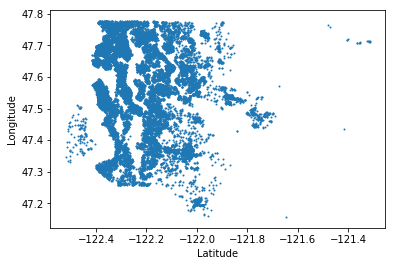

In [58]:
% matplotlib inline

plt.figure(figsize=(15,10))
df.plot.scatter('long','lat', s=1)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In an earlier model we dropped 'waterfront', 'yr_renovated', and 'view'; partly to deal with the zero-heavy data and partly to handle the missing values. For this model, we decided to keep the variables, change the NaNs to zeros and to change 'yr_renovated' to a simple binary variable, which basically captures whether a house has ever been renovated or not.

In [109]:
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'].isna().sum()

df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.loc[df['yr_renovated'] != 0, 'yr_renovated'] = 1

df['view'] = df['view'].fillna(0)

Decided to leverage 'zipcode'; hence, dropped 'lat' and 'long'.

Dropped 'id' because it wasn't meaningful for our purposes.

Dropped 'date' because it was not meaningfully varied (all dates between 2014 & 2015).

In [110]:
df = df.drop(columns=['lat', 'long', 'id', 'date'], axis=1)

Addressed presence of '?' in 'sqft_basement'; changed the datatype.

In [38]:
#df['sqft_basement'] = df['sqft_basement'].replace(to_replace='?', value='0').astype(str).astype(float).astype(int)

Dropped 'sqft_basement' because it was a zero-inflated variable, which would be challenging to work with for very little reward.

In [111]:
df = df.drop(columns=['sqft_basement'], axis=1)

In [25]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264306,0.393497,0.036056,0.667951,0.605368,0.053953,0.117543,-0.053402,0.585241,0.082845
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,0.356563,0.479386,0.155670,0.017635,-0.154092,0.393406,0.030690
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,0.665838,0.686668,0.507173,0.046742,-0.204786,0.569884,0.088303
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,0.762779,0.876448,0.318152,0.050829,-0.199802,0.756402,0.184342
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,0.114731,0.184139,0.052946,0.005091,-0.129586,0.144763,0.718204
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,0.458794,0.523989,0.489193,0.003713,-0.059541,0.280102,-0.010722
waterfront,0.264306,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,0.082818,0.071778,-0.024487,0.074267,0.028923,0.083823,0.030658
view,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,0.249082,0.166017,-0.054452,0.090480,0.085059,0.278928,0.073083
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,-0.146896,-0.158904,-0.361592,-0.055383,0.002888,-0.093072,-0.003126
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.082818,0.249082,-0.146896,1.000000,0.756073,0.447865,0.015259,-0.185771,0.713867,0.120981


Dropped 'sqft_above', 'bathrooms', 'grade', 'sqft_living15' for colinearity with 'sqft_living' [used a .75 threshhold].

In [112]:
df_dropped = df.drop(columns=['sqft_above', 'sqft_living15', 'bathrooms', 'grade'], axis=1)

Dropped 1.3% of data (284 observations out of 21,597). A number of a outliers and top-end influencers that were impacting different independent variables.

In [113]:
indexNames = df_dropped[df_dropped['sqft_living'] >= 5000].index
df_dropped.drop(indexNames, inplace=True)

indexNames2 = df_dropped[df_dropped['bedrooms'] >= 8].index
df_dropped.drop(indexNames2, inplace=True)

indexNames3 = df_dropped[df_dropped['sqft_lot'] > 400000].index
df_dropped.drop(indexNames3, inplace=True)

indexNames4 = df_dropped[df_dropped['floors'] > 3.0].index
df_dropped.drop(indexNames4, inplace=True)

df_dropped.shape

(21313, 12)

In [28]:
df_dropped.corr()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,yr_built,yr_renovated,zipcode,sqft_lot15
price,1.000000,0.301720,0.658674,0.076871,0.258218,0.228351,0.381349,0.050724,0.040137,0.123276,-0.039223,0.060409
bedrooms,0.301720,1.000000,0.601117,0.041104,0.174992,-0.012270,0.063998,0.027958,0.165418,0.015052,-0.158621,0.028090
sqft_living,0.658674,0.601117,1.000000,0.180898,0.355343,0.068717,0.243786,-0.055257,0.329830,0.050592,-0.200616,0.161346
sqft_lot,0.076871,0.041104,0.180898,1.000000,-0.027852,0.024228,0.055470,-0.013527,0.061600,0.009105,-0.151817,0.788186
floors,0.258218,0.174992,0.355343,-0.027852,1.000000,0.014193,0.015799,-0.264831,0.491718,0.003607,-0.058485,-0.027392
waterfront,0.228351,-0.012270,0.068717,0.024228,0.014193,1.000000,0.372157,0.018975,-0.029486,0.072904,0.031220,0.035129
view,0.381349,0.063998,0.243786,0.055470,0.015799,0.372157,1.000000,0.048905,-0.066477,0.092743,0.095444,0.052479
condition,0.050724,0.027958,-0.055257,-0.013527,-0.264831,0.018975,0.048905,1.000000,-0.360061,-0.055690,0.000384,-0.000425
yr_built,0.040137,0.165418,0.329830,0.061600,0.491718,-0.029486,-0.066477,-0.360061,1.000000,-0.201839,-0.345161,0.066029
yr_renovated,0.123276,0.015052,0.050592,0.009105,0.003607,0.072904,0.092743,-0.055690,-0.201839,1.000000,0.062929,0.004381


Dropped 'sqft_lot15' because of colinearity concerns with 'sqft_lot'.

In [114]:
df_dropped.drop(columns=['sqft_lot15'], axis=1, inplace=True)

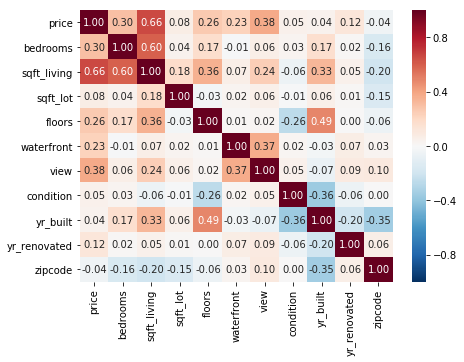

In [115]:
import seaborn as sns
#sns.heatmap(df_dropped.corr(), center=0);
correlation = df_dropped.corr()
plt.figure(figsize=(7, 5))
heatmap = sns.heatmap(correlation, annot=True, fmt = '.2f', linewidths=0, vmin=-1, cmap="RdBu_r")

In [342]:
#decade = ["{0}".format(year, year + 10) for year in range(1900, 2030, 10)]
#count_unique_decade = len(decade)

In [72]:
#df_dropped['decade_built'] = pd.cut(x=df_dropped['yr_built'], bins=count_unique_decade, labels=decade)
df_dropped.head()

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,yr_built,yr_renovated,zipcode
0,221900.0,3,1180,5650,1.0,0.0,0.0,3,1955,0.0,98178
1,538000.0,3,2570,7242,2.0,0.0,0.0,3,1951,1.0,98125
2,180000.0,2,770,10000,1.0,0.0,0.0,3,1933,0.0,98028
3,604000.0,4,1960,5000,1.0,0.0,0.0,5,1965,0.0,98136
4,510000.0,3,1680,8080,1.0,0.0,0.0,3,1987,0.0,98074


In [344]:
#df_dropped['decade_built'].astype(str).astype(float).head(2)

0    1960.0
1    1950.0
Name: decade_built, dtype: float64

In [345]:
#df_dropped.drop(columns=['yr_built'], axis=1, inplace=True)

Created dummy variables for 'yr_built', 'condition', and 'zipcode'.

In [116]:
#grade_dummies = pd.get_dummies(df_dropped['grade'], prefix="gd")
zip_dummies = pd.get_dummies(df_dropped['zipcode'], prefix="zp")
#decade_dummies = pd.get_dummies(df_dropped['decade_built'], prefix="dec")
year_dummies = pd.get_dummies(df_dropped['yr_built'], prefix="yr")
condition_dummies = pd.get_dummies(df_dropped['condition'], prefix="cond")
#floors_dummies = pd.get_dummies(df_dropped['floors'], prefix="floor")
#view_dummies = pd.get_dummies(df_dropped['view'], prefix="view")

df_dropped = df_dropped.drop(['zipcode', 'yr_built', 'condition'], axis=1)

df_dropped = pd.concat([df_dropped, zip_dummies, year_dummies, condition_dummies], axis=1)
df_dropped.head(2)

,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,yr_renovated,zp_98001,zp_98002,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,cond_1,cond_2,cond_3,cond_4,cond_5
0,221900.0,3,1180,5650,1.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,3,2570,7242,2.0,0.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,1,0,0


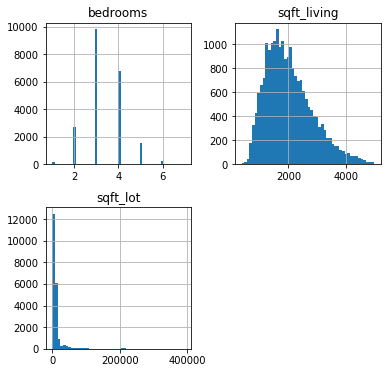

In [68]:
import matplotlib.pyplot as plt

%matplotlib inline

df_dropped[["sqft_living", "sqft_lot", "bedrooms"]].hist(bins=50, figsize  = [6, 6])
plt.show()

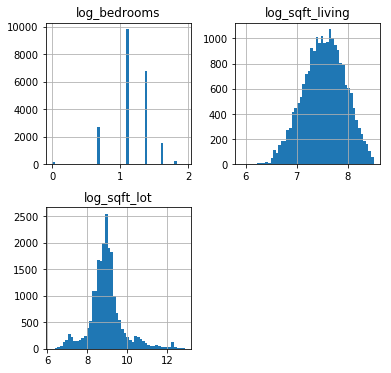

In [117]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

data_log = pd.DataFrame([])
data_log["log_sqft_living"] = np.log(df_dropped["sqft_living"])
data_log["log_sqft_lot"] = np.log(df_dropped["sqft_lot"])
#data_log["log_floors"] = np.log(df_dropped['floors'])
data_log["log_bedrooms"] = np.log(df_dropped["bedrooms"])
data_log.hist(bins=50, figsize  = [6, 6]);

Transformed 'sqft_living', 'sqft_lot' & 'bedrooms' to bring these features more in line with the assumptions of the normal distribution. Also, standardized these features using mean normalization.

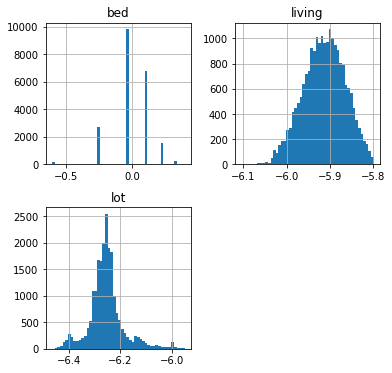

In [118]:
logbed = data_log["log_bedrooms"]
logsqftliving = data_log["log_sqft_living"]
logsqftlot = data_log["log_sqft_lot"]
#logfloors = data_log["log_floors"]

#Standardized using median & .75-.25 quartile normalization
#scaled_bed = (logbed-np.median(logbed))/(logbed.quantile(.75))-(logbed.quantile(.25))
#scaled_sqft_living = (logsqftliving-np.median(logsqftliving))/(logsqftliving.quantile(.75))-(logsqftliving.quantile(.25))
#scaled_sqft_lot = (logsqftlot-np.median(logsqftlot))/(logsqftlot.quantile(.75))-(logsqftlot.quantile(.25))

#Standardized using mean normalization
scaled_bed = (logbed-np.mean(logbed))/(max(logbed))-(min(logbed))
scaled_sqft_living = (logsqftliving-np.mean(logsqftliving))/(max(logsqftliving))-(min(logsqftliving))
scaled_sqft_lot = (logsqftlot-np.mean(logsqftlot))/(max(logsqftlot))-(min(logsqftlot))
#scaled_floors = (logfloors-np.mean(logfloors))/(max(logfloors)-min(logfloors))

data_cont_scaled = pd.DataFrame([])
data_cont_scaled["bed"]= scaled_bed
data_cont_scaled["living"]= scaled_sqft_living
data_cont_scaled["lot"] = scaled_sqft_lot
#data_cont_scaled["floors"] = scaled_floors

data_cont_scaled.hist(bins=50, figsize  = [6, 6]);

In [119]:
df_dropped['bedrooms'] = data_cont_scaled["bed"]
df_dropped['sqft_living'] = data_cont_scaled["living"]
df_dropped['sqft_lot'] = data_cont_scaled["lot"]
#df_dropped['floors'] = data_cont_scaled["floors"]

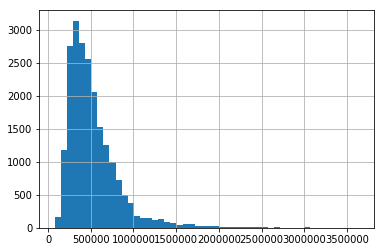

In [95]:
df_dropped['price'].hist(bins=50)
plt.show()

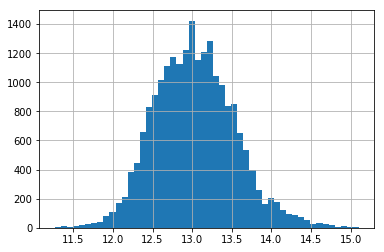

In [99]:
df_dropped['log_price'].hist(bins=50)
plt.show()

Changed our outcome variable from 'price' to 'log_price'. The distribution of 'log_price' better fits that of a normal distribution than the right-skewed distribution of 'price'.

In [120]:
df_dropped['log_price'] = np.log(df_dropped['price'])

In [121]:
df_dropped.drop(columns=['price'], axis=1, inplace=True)

In [122]:
df_dropped.head(3)

,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,yr_renovated,zp_98001,zp_98002,zp_98003,...,yr_2012,yr_2013,yr_2014,yr_2015,cond_1,cond_2,cond_3,cond_4,cond_5,log_price
0,-0.038467,-5.968133,-6.279494,1.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,12.309982
1,-0.038467,-5.876699,-6.260221,2.0,0.0,0.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,13.195614
2,-0.246835,-6.018276,-6.235168,1.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,12.100712


In [261]:
#import pandas as pd
#from sklearn import preprocessing

#float_array = df_dropped['sqft_living'].values.astype(float)
#min_max_scaler = preprocessing.MinMaxScaler()
#np_scaled = min_max_scaler.fit_transform(float_array)
#df_normalized = pd.DataFrame(np_scaled)
#df_normalized.head()

With our ols model completed, we're ready to import the necessary libraries and run the model.

In [123]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

In [11]:
#formula = "price ~ sqft_living+floors+bedrooms+sqft_living15"
#model = ols(formula= formula, data=df_dropped).fit()

In [124]:
outcome = 'log_price'
predictors = df_dropped.drop('log_price', axis=1)

pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [126]:
model = ols(formula= formula, data=df_dropped).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     657.9
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:38:37   Log-Likelihood:                 5030.5
No. Observations:               21313   AIC:                            -9669.
Df Residuals:                   21117   BIC:                            -8108.
Df Model:                         195                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       41.6352      0.224    186.052      0.000      41.197      42.074
bedrooms        -0.1209      0.013     -9.497      0.000      -0.146      -0.096
sqft_living      5.1116      0.047    108.908      0.000       5.020       5.204
sqft_lot         1.2445      0.030     40.960      0.000       1.185       1.304
floors           0.0078      0.004      2.069      0.039       0.000       0.015
waterfront       0.4467      0.019     23.672      0.000       0.410       0.484
view             0.0870      0.002     41.969      0.000       0.083       0.091
yr_renovated     0.0762      0.008      9.851      0.000       0.061       0.091
zp_98001         0.0655      0.011      6.115      0.000       0.044       0.086
zp_98002         0.0450      0.014      3.172      0.002       0.017       0.073
zp_98003         0.1398      0.012     11.575      0.000       0.116       0.163
zp_98004         1.3251      0.012    114.892      0.000       1.303       1.348
zp_98005         0.9543      0.015     63.084      0.000       0.925       0.984
zp_98006         0.8464      0.009     89.901      0.000       0.828       0.865
zp_98007         0.8456      0.017     51.162      0.000       0.813       0.878
zp_98008         0.8215      0.012     67.165      0.000       0.797       0.845
zp_98010         0.2683      0.020     13.722      0.000       0.230       0.307
zp_98011         0.5726      0.014     40.808      0.000       0.545       0.600
zp_98014         0.3039      0.018     16.842      0.000       0.269       0.339
zp_98019         0.3531      0.014     24.626      0.000       0.325       0.381
zp_98022         0.0628      0.014      4.635      0.000       0.036       0.089
zp_98023         0.1056      0.009     11.198      0.000       0.087       0.124
zp_98024         0.4460      0.022     19.976      0.000       0.402       0.490
zp_98027         0.6376      0.010     63.836      0.000       0.618       0.657
zp_98028         0.5263      0.012     44.609      0.000       0.503       0.549
zp_98029         0.7565      0.012     65.383      0.000       0.734       0.779
zp_98030         0.1289      0.013     10.285      0.000       0.104       0.153
zp_98031         0.1731      0.012     14.124      0.000       0.149       0.197
zp_98032         0.1005      0.018      5.710      0.000       0.066       0.135
zp_98033         0.9364      0.010     95.642      0.000       0.917       0.956
zp_98034         0.6818      0.009     74.278      0.000       0.664       0.700
zp_98038         0.2242      0.009     25.328      0.000       0.207       0.242
zp_98039         1.5467      0.029     52.570      0.000       1.489       1.604
zp_98040         1.1205      0.012     91.878      0.000       1.097       1.144
zp_98042         0.1479      0.009     16.188      0.000       0.130       0.166
zp_98

Using train-test-split, we see how the model does training on 75% of the data and being tested on 25%.

In [130]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_dropped, test_size=0.25)

In [35]:
len(train)

15984

In [36]:
len(test)

5329

In [131]:
outcome = 'log_price'
predictors = train.drop('log_price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

In [132]:
model = ols(formula= formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     494.2
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:40:51   Log-Likelihood:                 3871.4
No. Observations:               15984   AIC:                            -7351.
Df Residuals:                   15788   BIC:                            -5846.
Df Model:                         195                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       41.8671      0.258    162.207      0.000      41.361      42.373
bedrooms        -0.1311      0.015     -8.941      0.000      -0.160      -0.102
sqft_living      5.1250      0.054     94.829      0.000       5.019       5.231
sqft_lot         1.2755      0.035     36.468      0.000       1.207       1.344
floors           0.0099      0.004      2.293      0.022       0.001       0.018
waterfront       0.4070      0.022     18.172      0.000       0.363       0.451
view             0.0872      0.002     36.685      0.000       0.083       0.092
yr_renovated     0.0820      0.009      9.221      0.000       0.065       0.099
zp_98001         0.0711      0.012      5.878      0.000       0.047       0.095
zp_98002         0.0450      0.016      2.837      0.005       0.014       0.076
zp_98003         0.1343      0.014      9.797      0.000       0.107       0.161
zp_98004         1.3130      0.013     97.415      0.000       1.287       1.339
zp_98005         0.9390      0.017     54.065      0.000       0.905       0.973
zp_98006         0.8497      0.011     78.066      0.000       0.828       0.871
zp_98007         0.8556      0.019     44.856      0.000       0.818       0.893
zp_98008         0.8185      0.014     57.957      0.000       0.791       0.846
zp_98010         0.2790      0.022     12.550      0.000       0.235       0.323
zp_98011         0.5790      0.016     37.174      0.000       0.548       0.610
zp_98014         0.3148      0.020     15.501      0.000       0.275       0.355
zp_98019         0.3501      0.017     20.680      0.000       0.317       0.383
zp_98022         0.0576      0.016      3.675      0.000       0.027       0.088
zp_98023         0.1111      0.011     10.209      0.000       0.090       0.132
zp_98024         0.4698      0.027     17.589      0.000       0.417       0.522
zp_98027         0.6348      0.012     53.516      0.000       0.612       0.658
zp_98028         0.5364      0.013     40.090      0.000       0.510       0.563
zp_98029         0.7578      0.013     56.508      0.000       0.732       0.784
zp_98030         0.1265      0.014      8.729      0.000       0.098       0.155
zp_98031         0.1662      0.014     11.775      0.000       0.139       0.194
zp_98032         0.0992      0.019      5.092      0.000       0.061       0.137
zp_98033         0.9335      0.011     82.899      0.000       0.911       0.956
zp_98034         0.6836      0.010     65.296      0.000       0.663       0.704
zp_98038         0.2293      0.010     22.168      0.000       0.209       0.250
zp_98039         1.5793      0.035     45.575      0.000       1.511       1.647
zp_98040         1.1176      0.014     80.027      0.000       1.090       1.145
zp_98042         0.1516      0.010     14.478      0.000       0.131       0.172
zp_98

In [133]:
model = ols(formula= formula, data=test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     168.3
Date:                Thu, 20 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:41:00   Log-Likelihood:                 1310.2
No. Observations:                5329   AIC:                            -2228.
Df Residuals:                    5133   BIC:                            -938.6
Df Model:                         195                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       40.9886      0.452     90.649      0.000      40.102      41.875
bedrooms        -0.0902      0.026     -3.485      0.000      -0.141      -0.039
sqft_living      5.0895      0.095     53.506      0.000       4.903       5.276
sqft_lot         1.1438      0.062     18.500      0.000       1.023       1.265
floors           0.0022      0.008      0.282      0.778      -0.013       0.017
waterfront       0.5375      0.036     15.065      0.000       0.468       0.607
view             0.0841      0.004     19.660      0.000       0.076       0.092
yr_renovated     0.0610      0.016      3.819      0.000       0.030       0.092
zp_98001         0.0428      0.023      1.853      0.064      -0.002       0.088
zp_98002         0.0496      0.032      1.566      0.117      -0.012       0.112
zp_98003         0.1618      0.025      6.349      0.000       0.112       0.212
zp_98004         1.3570      0.022     60.830      0.000       1.313       1.401
zp_98005         0.9966      0.031     32.488      0.000       0.936       1.057
zp_98006         0.8350      0.019     44.357      0.000       0.798       0.872
zp_98007         0.8116      0.033     24.550      0.000       0.747       0.876
zp_98008         0.8309      0.025     33.881      0.000       0.783       0.879
zp_98010         0.2472      0.041      6.021      0.000       0.167       0.328
zp_98011         0.5462      0.032     16.908      0.000       0.483       0.610
zp_98014         0.2709      0.039      6.877      0.000       0.194       0.348
zp_98019         0.3643      0.027     13.464      0.000       0.311       0.417
zp_98022         0.0816      0.027      3.014      0.003       0.029       0.135
zp_98023         0.0882      0.019      4.655      0.000       0.051       0.125
zp_98024         0.3820      0.041      9.325      0.000       0.302       0.462
zp_98027         0.6447      0.019     34.595      0.000       0.608       0.681
zp_98028         0.4882      0.025     19.527      0.000       0.439       0.537
zp_98029         0.7567      0.023     33.128      0.000       0.712       0.801
zp_98030         0.1373      0.025      5.499      0.000       0.088       0.186
zp_98031         0.2059      0.025      8.313      0.000       0.157       0.254
zp_98032         0.1168      0.041      2.848      0.004       0.036       0.197
zp_98033         0.9447      0.020     47.637      0.000       0.906       0.984
zp_98034         0.6762      0.019     35.314      0.000       0.639       0.714
zp_98038         0.2131      0.017     12.395      0.000       0.179       0.247
zp_98039         1.4686      0.056     26.095      0.000       1.358       1.579
zp_98040         1.1294      0.025     45.133      0.000       1.080       1.178
zp_98042         0.1375      0.019      7.342      0.000       0.101       0.174
zp_98

In [ ]:
# Another possible target variable to consider is log(price/sqft)

In [143]:
# [Random note: savefig as .png or .jpg ~ better and more durable than screenshot and paste]

Pursuing Cross-validation testing of our model in the section below:

In [135]:
y = df_dropped['log_price']
X = df_dropped.drop('log_price', axis=1)

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [137]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17050 4263 17050 4263


In [138]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [139]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [140]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.03635487744797934
Test Mean Squarred Error: 0.037628620381973614


In [141]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

In [142]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-0.03756712511008699
-0.03753783944181445
-0.037378384212938
